__Zillow housing data:__

goal- determine the 5 best zip codes to invest in using predictive modeling with time series



# imports, functions

In [1]:
# import
import warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import pandas_profiling
import datetime
import plotly_express as px 
from pandas import read_csv
import itertools
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
import seaborn as sns
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import log
import matplotlib.dates as mdates
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
rcParams['figure.figsize'] = 18, 8

In [ ]:
# functions

#check stationarity:

def is_stationary(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        


In [2]:
# melt function provided by FlatIron
# by zip code: df with dates as index, home values for column

# def melt_data(df):
#     melted = pd.melt(df, id_vars=['RegionName'], var_name='date')
#     melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('date').aggregate({'value':'mean'})

In [3]:
df = pd.read_csv('zillow_data.csv')

# explore, scrub

Zillow's housing records data:

In [4]:
#import zillow df, get basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
#isolating non-date data for pandas_profiling
pandas_profiling.ProfileReport(df.iloc[:,0:7])

Number of variables,7
Number of observations,14723
Total Missing (%),1.0%
Total size in memory,805.2 KiB
Average record size in memory,56.0 B
Numeric,3
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
#remove unneeded columns
cols_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
wide_df = df.drop(cols_drop, axis=1)

# convert RegionName values to string
wide_df['RegionName'] = wide_df['RegionName'].astype(str)
# wide_df.set_index('RegionName', inplace = True)
wide_df.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [7]:
# how many columns(dates) missing more than 10% 
len(wide_df.columns[wide_df.isnull().mean() > .10])

#percent of zip codes missing more than 10%
len(wide_df[wide_df.isna().mean(axis=1) > .10])/ len(wide_df)

0

0.07036609386673912

In [8]:
#drop all rows with null values
wide_df = wide_df.dropna()

## OR:
# fill null values with average between two adjacent existing values
# df = (df.ffill(axis=1)+df.bfill(axis=1))/2

# reshape

In [9]:
#transpose data(flip to set dates as index, zip codes as columns)
df = wide_df.T
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

#covert index to datetime
df.index = pd.to_datetime(df.index)
df = df.astype(int)
df.head()

,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900


# choose zip codes

In [36]:
df= np.log(df)

In [ ]:
# # changes in pricing by zipcode
# # increase in value dollar amount 
# df['difference'] = df['2018-04']- df['1996-04']

# # increase in last 5 years
# df['5_yr'] = df['2018-04']- df['2013-04']

# # rate of increase
# df['yr_rate'] = df['difference']/ 22

# # percent increase
# df['perc_inc'] = df['difference']/ df['1996-04']

# print('by size:')
# #df.head(10)

# print('by highest average yearly increase:')
# df.sort_values('yr_rate',ascending = False).head(10)

# print('by last 5 yr increase')
# df.sort_values('5_yr', ascending = False).head(10)

# print('by highest percent increase from Apr. 1996')
# df.sort_values('perc_inc',ascending = False).head(10)

# # standard deviation of monthly values
# df['std']=df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

# # # mean from 1996 - 2018
# # mean=df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
# # # coefficient of variance
# # df['var']=df['std']/mean

# # # variance
# # df['vari']=df.loc[:,'1996-04':'2018-04'].var(skipna=True, axis=1)




# visuals

In [ ]:
df= np.log(df)

In [72]:
zip_1 = df['60657']
zip_2 = df['78704']
zip_3 = df['93638']
zip_4 = df['98312']
zip_5 = df['98109']

top_zips = [zip_1, zip_2, zip_3, zip_4, zip_5]

In [68]:
is_stationary(zip_1)

ADF Statistic: -3.406489
p-value: 0.010740
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


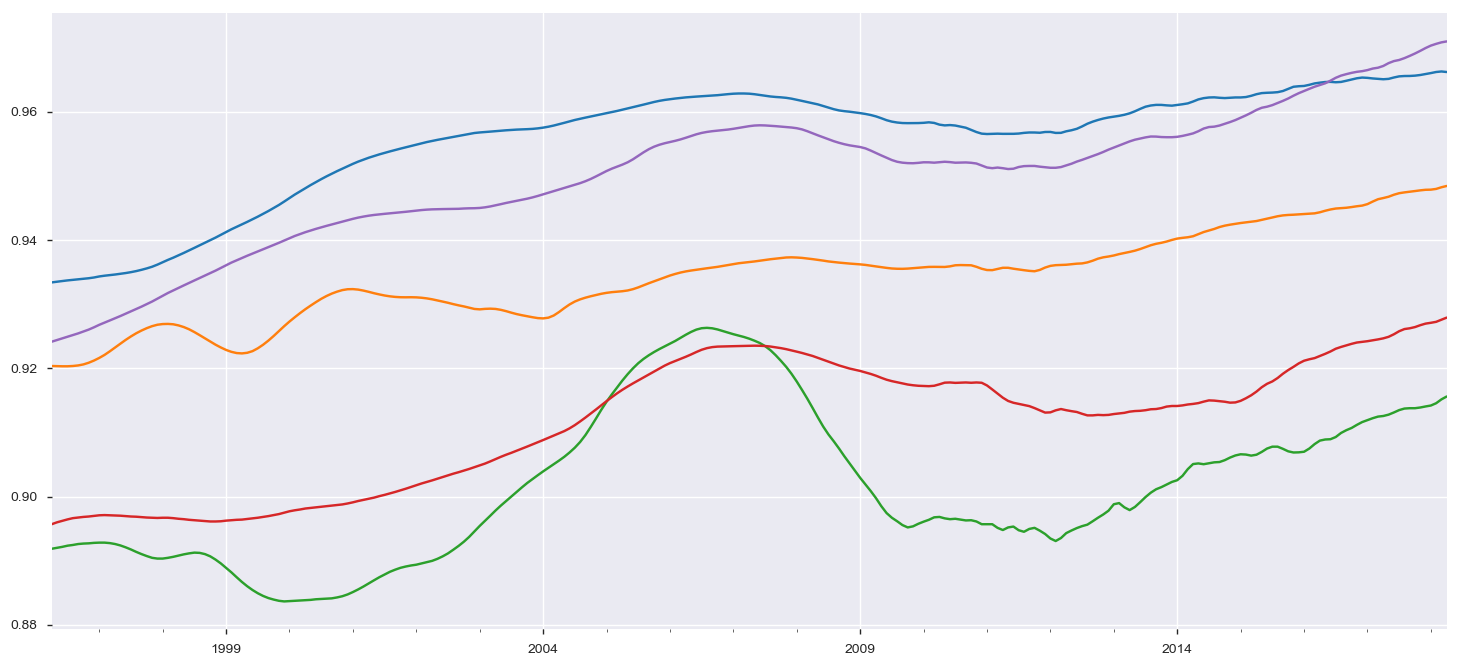

In [83]:
for zip in top_zips:
    zip.plot();

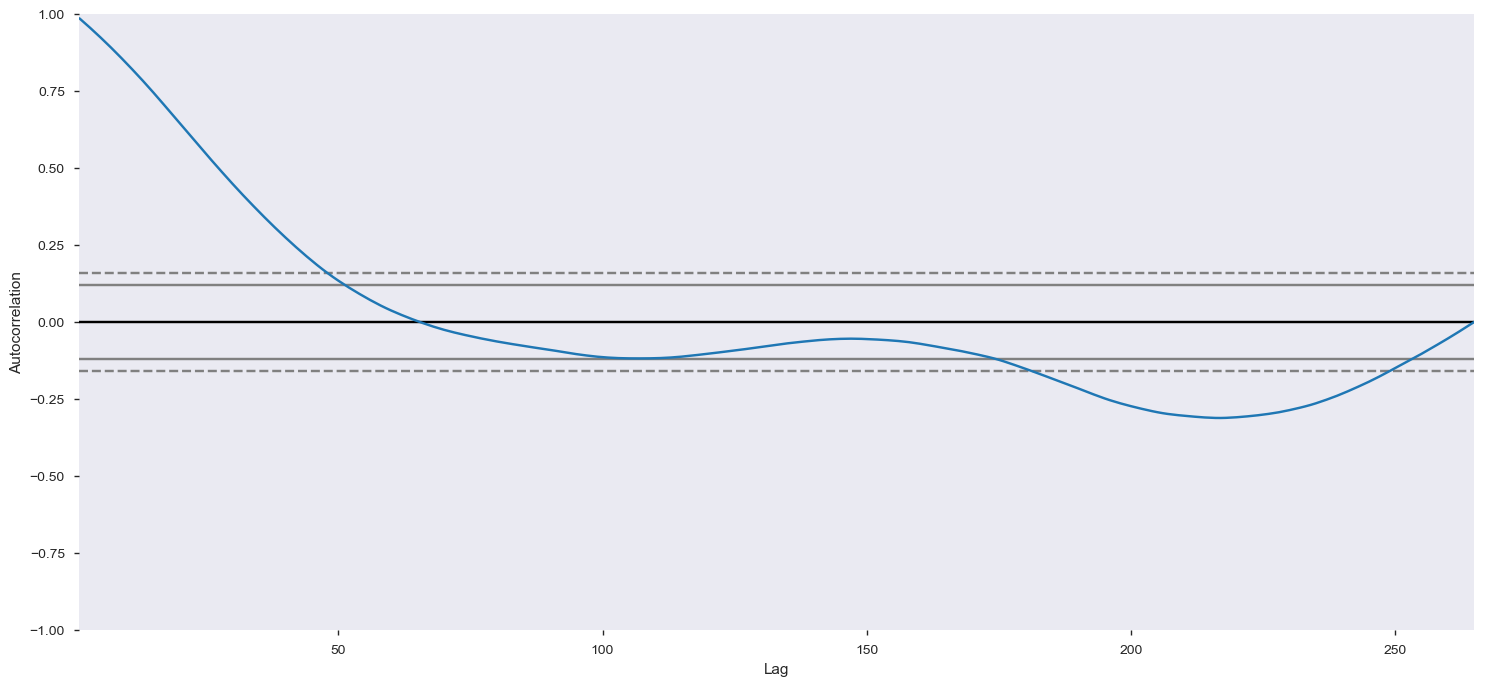

In [52]:
autocorrelation_plot(zip_1);

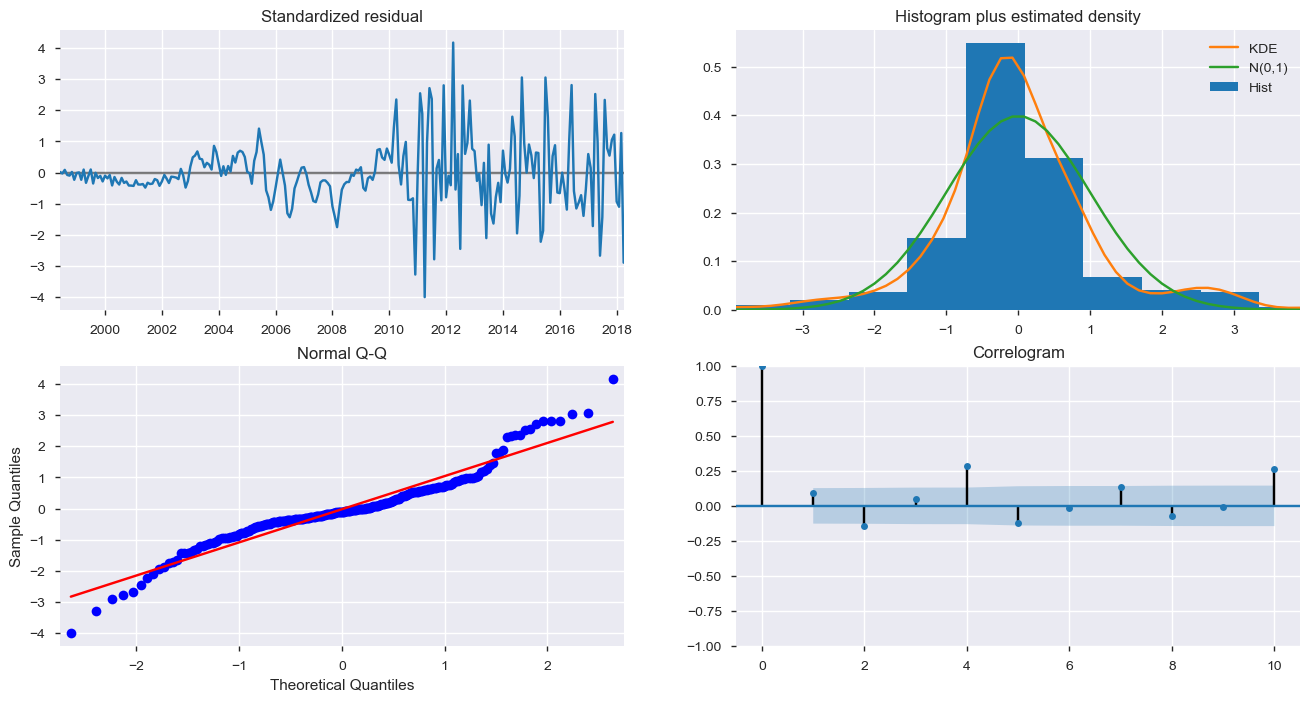

In [101]:
def print_results(data):
    mod = sm.tsa.statespace.SARIMAX(data
                                , order=(1, 1, 1)
                                , seasonal_order=(1, 1, 0, 12)
                                , enforce_stationarity=False
                                , enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show();

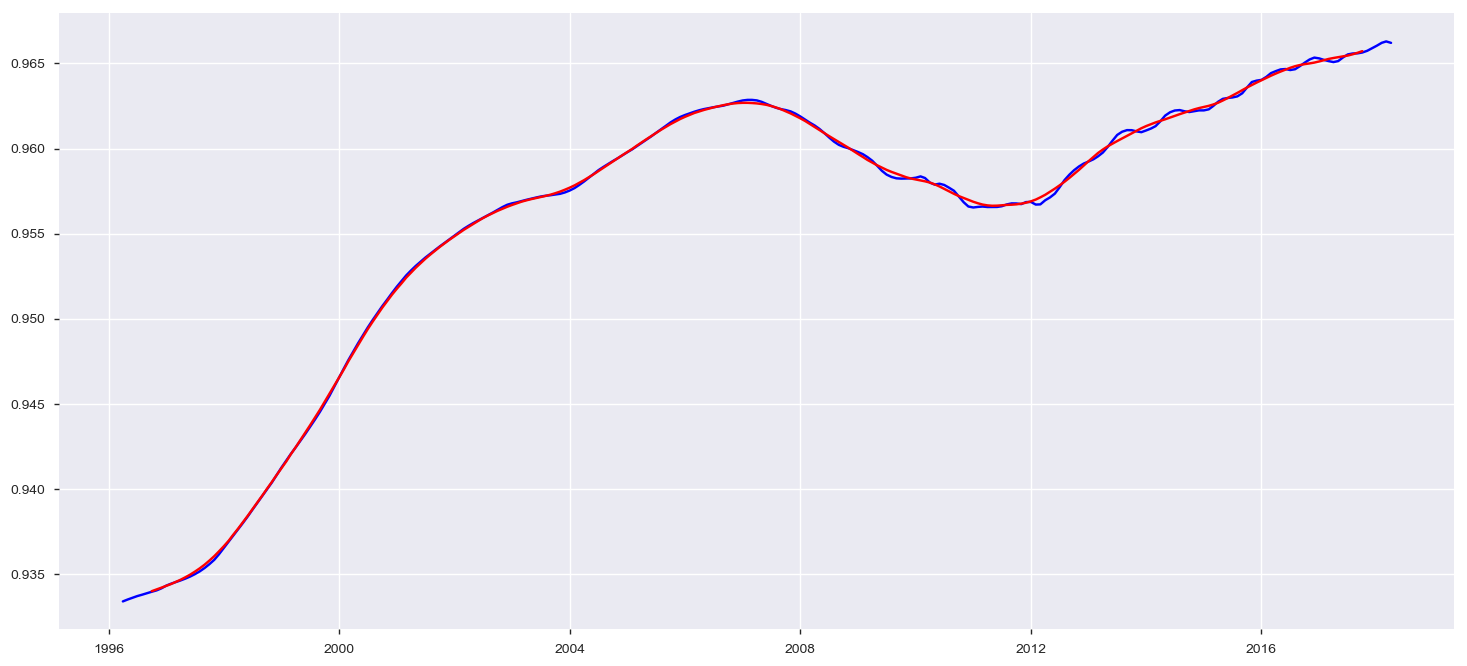

In [80]:
#observed vs. predicted
decomposition = sm.tsa.seasonal_decompose(zip_1)
fig, ax = plt.subplots()
plt.plot(zip_1.index, zip_1, c='blue');
plt.plot(decomposition.trend.index, decomposition.trend, c='red');

# unneccessary
# ax.grid(True)
# year = mdates.YearLocator(month=1)
# month = mdates.MonthLocator(interval=3)
# year_format = mdates.DateFormatter('%Y')
# month_format = mdates.DateFormatter('%m')
# ax.xaxis.set_minor_locator(month)
# ax.xaxis.grid(True, which = 'minor')
# ax.xaxis.set_major_locator(year)
# ax.xaxis.set_major_formatter(year_format)

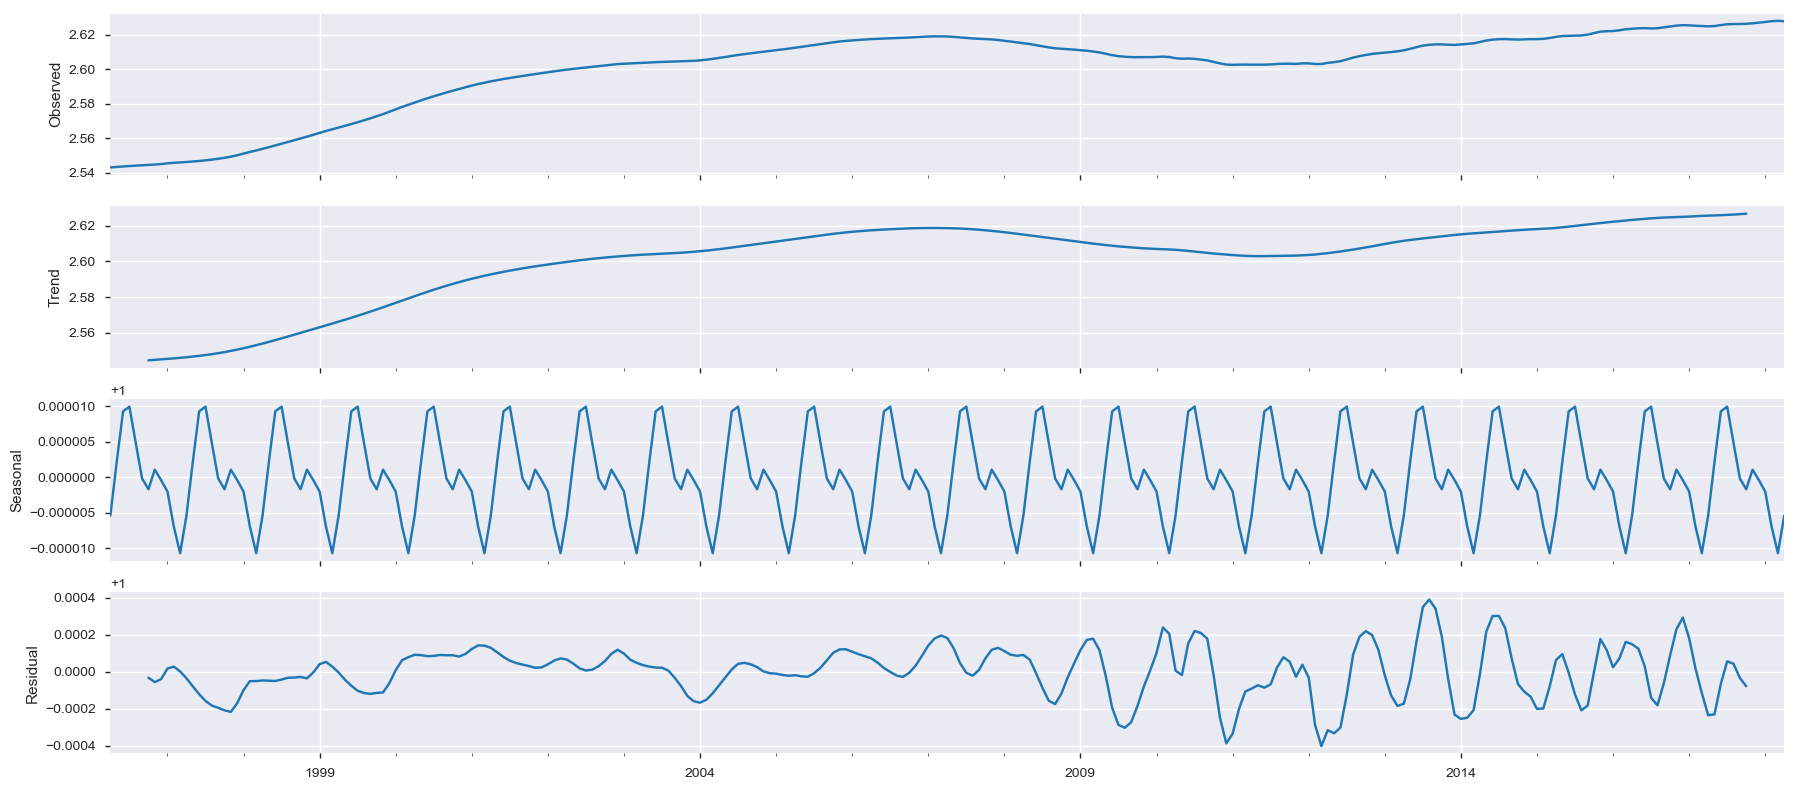

In [59]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(zip_1 , model='multiplitive')
fig = decomposition.plot()
plt.show()

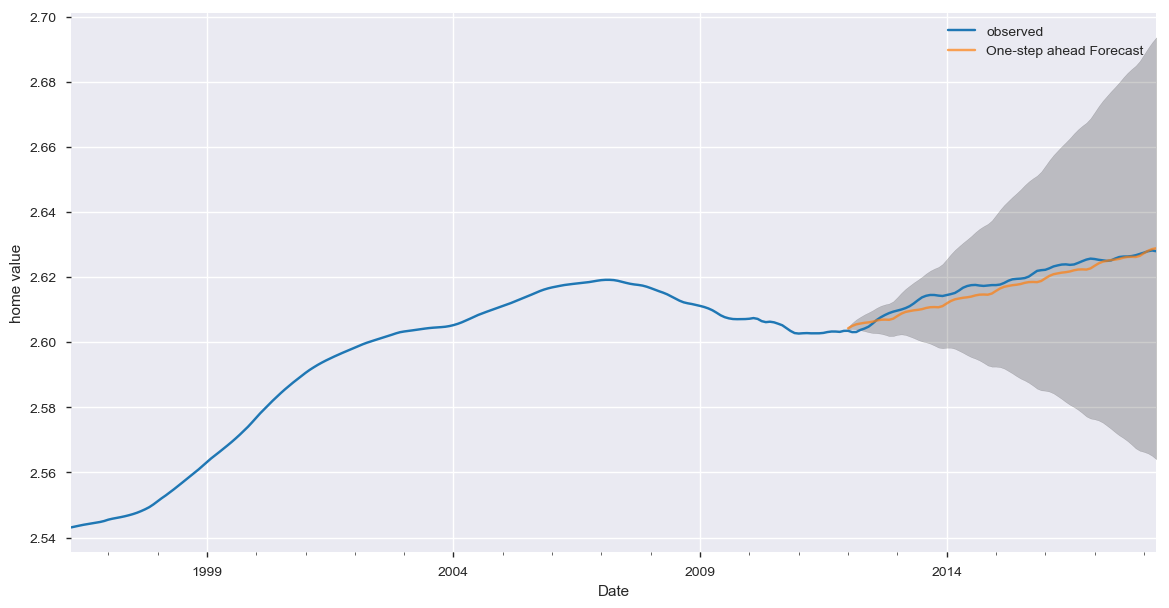

In [65]:
pred = results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = zip_1.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('home value')
plt.legend()
plt.show();

In [100]:

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], order=(1,0,1))
fit_res = mod.fit(disp=False)
print(fit_res.summary())

NameError: name 'endog' is not defined

In [ ]:
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
res = mod.filter(fit_res.params)

predict = res.get_prediction()
predict_ci = predict.conf_int()
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='1978-01-01')
predict_dy_ci = predict_dy.conf_int()

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [88]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    
#     Summary:
#     -------
#     Plots various plots, including time series, autocorrelation,
#     partial autocorrelation and distribution plots of data.
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Sales')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=48);
    plot_pacf(data, ax=axes[0,1], lags=48);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

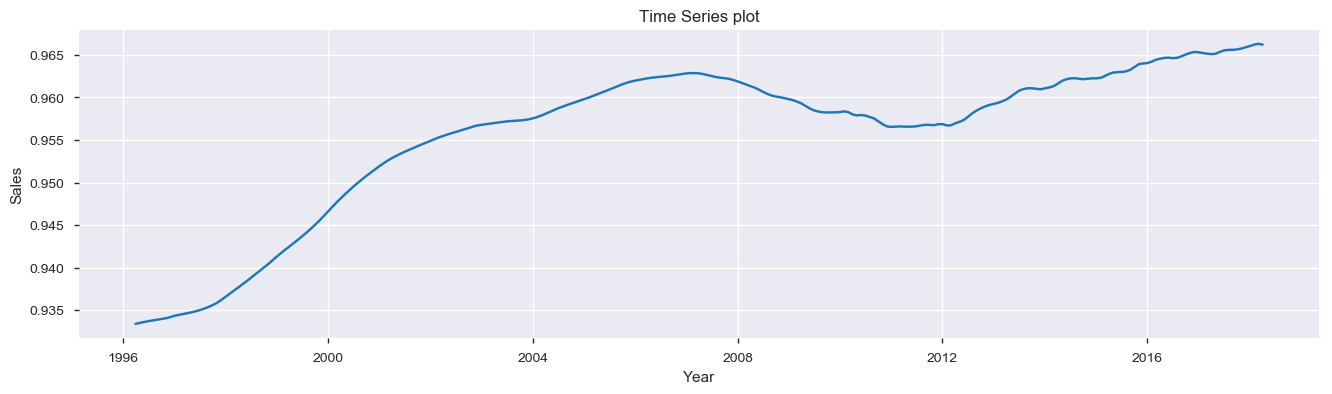

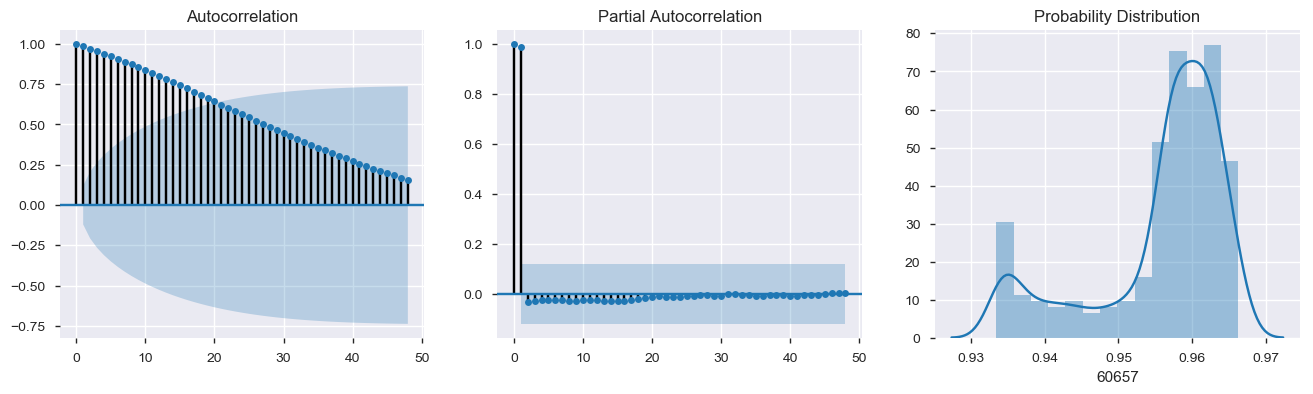

In [89]:
plot_data_properties(zip_1)

In [91]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
test_start_date = '2000-01-01'
training_data = zip_1[:test_start_date]
test_data = zip_1[test_start_date:]

def plot_seasonal_decompose(data, model):
    '''
    Summary:
    -------
    Plots trend, seasonality and residuals with bigger plot size=(10,2)
    
    Parameters:
    ----------
    data(pd.Dataframe, pd.Series): time series data
    
    Return:
    ------
    decomposition(obj): return value of statsmodels.tsa.seasonal.seasonal_decompose
    '''
    decomposition = seasonal_decompose(data,model=model)
    decomposition.trend.plot(figsize=(10,2), title='Trend');
    decomposition.seasonal.plot(figsize=(10,2), title='Seasonality');
    decomposition.resid.plot(figsize=(10,2), title='Residuals');
    return decomposition

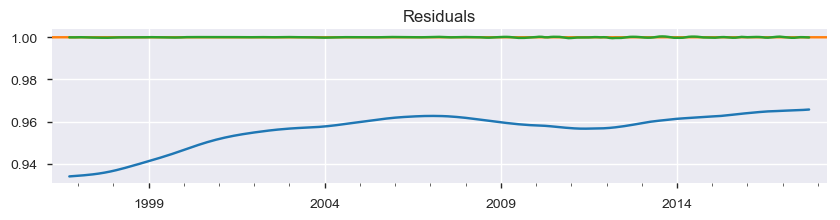

In [92]:
plot_seasonal_decompose(zip_1, 'multiplicative')

In [93]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(zip_1)
plt.plot(moving_avg, color='red')

AttributeError: module 'pandas' has no attribute 'rolling_mean'

In [94]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data):
    '''
    Summary:
    -------
    Performs Adfuller test on given time series data to test stationarity.
    p_val >= 0.05 means the data is not stationary, otherwise (p_val < 0.05) it is stationary.
    
    Parameters:
    data(pd.Dataframe, pd.Series. np.array): Time series data to be tested
    
    Return:
    ------
    '''
    p_val=adfuller(data['SPCS20RPSNSA'])[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))

In [95]:
test_stationarity(zip_1)

KeyError: 'SPCS20RPSNSA'

# ignore